# Forecasting for Banking Using Time Series Methods, Lab session 1
© Hugo Bourrousse  
September 2025

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Load the Excel file with all worksheets
file_path = r"C:\Users\hbourrou\Python\Data\bsi_dataset.xlsx" #r"/Users/hugo/Python/bsi_dataset.xlsx" 

# Load the data into a dictionary of dataframes (the None option for sheet_name creates a dictionary of dataframes)
excel_data = pd.read_excel(file_path, sheet_name=None)

# Extract worksheet names and display info to make sure everything worked fine
sheet_names = list(excel_data.keys())
print(f"Found {len(sheet_names)} worksheets: {sheet_names}")

Found 6 worksheets: ['BSI', 'GDP', 'int rate short', 'int rate long', 'Comp ind syst stress', 'HICP']


## Cleaning data
Below we work on the individual dataframes to make them consistent.   
The analysis focuses on Germany, and the monthly variables (interest rates, CISS) are converted to quarterly by averaging observations within quarters.

**Note:** for this type of easy dataset, it would be cleaner to do the treatment directly in Excel (i.e. import here only the relevant variables for Germany)

In [3]:
# create a dataframe for each worksheet and clean after
for i, (sheet_name, df) in enumerate(excel_data.items()):
    locals()[f"df{i+1}"] = df

In [4]:
# Ok, let's do the dirty cleaning now
df1.head(5)

,Unnamed: 0,"Germany, Loans, Total, Euro area (changing composition), Unspecified counterpart sector","Spain, Loans, Total, Euro area (changing composition), Unspecified counterpart sector","France, Loans, Total, Euro area (changing composition), Unspecified counterpart sector","Italy, Loans, Total, Euro area (changing composition), Unspecified counterpart sector","Germany, Deposit liabilities, Total, Euro area (changing composition), Unspecified counterpart sector","Spain, Deposit liabilities, Total, Euro area (changing composition), Unspecified counterpart sector","France, Deposit liabilities, Total, Euro area (changing composition), Unspecified counterpart sector","Italy, Deposit liabilities, Total, Euro area (changing composition), Unspecified counterpart sector","Germany, Capital and reserves, World not allocated (geographically), Unspecified counterpart sector","Spain, Capital and reserves, World not allocated (geographically), Unspecified counterpart sector","France, Capital and reserves, World not allocated (geographically), Unspecified counterpart sector","Italy, Capital and reserves, World not allocated (geographically), Unspecified counterpart sector"
0,NaN,(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro),(Millions of Euro)
1,1997-Q4,3415366,NaN,NaN,NaN,2987309,NaN,NaN,NaN,197963,NaN,NaN,NaN
2,1998-Q1,3435838,NaN,NaN,NaN,3005318,NaN,NaN,NaN,202938,NaN,NaN,NaN
3,1998-Q2,3517512,NaN,NaN,NaN,3064839,NaN,NaN,NaN,207787,NaN,NaN,NaN
4,1998-Q3,3566887,NaN,NaN,NaN,3088691,NaN,NaN,NaN,207969,NaN,NaN,NaN


so what has to be done:
- drop the first row
- deal with the index
- keep only the variables related to Germany and remane them appropriately

In [5]:
df1 = df1.drop(index=0).reset_index(drop=True)
df1 = df1.set_index(pd.to_datetime(df1['Unnamed: 0']))
df1.index.name = 'date'

de_columns = [col for col in df1.columns if 'Germany' in col]
df1 = df1[de_columns]

# rename the column so that match the EViews script
df1.columns = ['de_loan', 'de_dep', 'de_cap']
df1 = df1.apply(pd.to_numeric, errors='coerce') # this converts to numeric variables (not stored like this)
df1.head(5)

C:\Users\hbourrou\AppData\Local\Temp\ipykernel_24788\3571834084.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1 = df1.set_index(pd.to_datetime(df1['Unnamed: 0']))


,de_loan,de_dep,de_cap
date,,,
1997-10-01,3415366,2987309,197963
1998-01-01,3435838,3005318,202938
1998-04-01,3517512,3064839,207787
1998-07-01,3566887,3088691,207969
1998-10-01,3698872,3237024,212630


Now we do the same thing for the other 5 data frames...

In [6]:
# df2: GDP
df2 = df2.drop(index=0).reset_index(drop=True)
df2 = df2.set_index(pd.to_datetime(df2['Unnamed: 0']))
df1.index.name = 'date'

de_columns = [col for col in df2.columns if 'Germany' in col]
df2 = df2[de_columns]
df2 = df2.rename(columns={df2.columns[0]: 'de_gdp'})
df2 = df2.apply(pd.to_numeric, errors='coerce')
df2.head(5)

C:\Users\hbourrou\AppData\Local\Temp\ipykernel_24788\245368490.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2 = df2.set_index(pd.to_datetime(df2['Unnamed: 0']))


,de_gdp
Unnamed: 0,
1997-10-01,506217.29
1998-01-01,481205.72
1998-04-01,492703.92
1998-07-01,509263.72
1998-10-01,521496.95


In [7]:
# df3: short interest rates
# Here the data are at the monthly frequency, so we need to take care of that and average over each quarter
df3 = df3.drop(index=0).reset_index(drop=True)
df3 = df3.set_index(pd.to_datetime(df3['Unnamed: 0'], format='%Y-%m'))
df3.index.name = 'date'

de_columns = [col for col in df3.columns if 'Germany' in col]
df3 = df3[de_columns]
df3 = df3.rename(columns={df3.columns[0]: 'de_ints'})
df3 = df3.apply(pd.to_numeric, errors='coerce')
df3 = df3.resample('QE').mean()
df3.head(5)

,de_ints
date,
2000-03-31,2.730000
2000-06-30,2.730000
2000-09-30,2.743333
2000-12-31,2.743333
2001-03-31,2.740000


In [8]:
# df4: long interest rates
# Here the data are at the monthly frequency, so we need to take care of that and average over each quarter
df4 = df4.drop(index=0).reset_index(drop=True)
df4 = df4.set_index(pd.to_datetime(df4['Unnamed: 0'], format='%Y-%m'))
df4.index.name = 'date'

de_columns = [col for col in df4.columns if 'Germany' in col]
df4 = df4[de_columns]
df4 = df4.rename(columns={df4.columns[0]: 'de_intl'})
df4 = df4.apply(pd.to_numeric, errors='coerce')
df4 = df4.resample('QE').mean()
df4.head(5)

,de_intl
date,
1997-12-31,5.490000
1998-03-31,5.000000
1998-06-30,4.886667
1998-09-30,4.386667
1998-12-31,4.013333


In [9]:
# df5: 'Comp ind syst stress', also monthly
df5 = df5.drop(index=0).reset_index(drop=True)
df5 = df5.set_index(pd.to_datetime(df5['Unnamed: 0'], format='%Y-%m'))
df5.index.name = 'date'

de_columns = [col for col in df5.columns if 'Germany' in col]
df5 = df5[de_columns]
df5 = df5.rename(columns={df5.columns[0]: 'de_ciss'})
df5 = df5.apply(pd.to_numeric, errors='coerce')
df5 = df5.resample('QE').mean()
df5.head(5)

,de_ciss
date,
2000-09-30,0.108300
2000-12-31,0.105200
2001-03-31,0.082767
2001-06-30,0.089267
2001-09-30,0.058867


In [10]:
# df6: HICP, also monthly
df6 = df6.drop(index=0).reset_index(drop=True)
df6 = df6.set_index(pd.to_datetime(df6['Unnamed: 0'], format='%Y-%m'))
df6.index.name = 'date'

de_columns = [col for col in df6.columns if 'Germany' in col]
df6 = df6[de_columns]
df6 = df6.rename(columns={df6.columns[0]: 'de_hicp'})
df6 = df6.apply(pd.to_numeric, errors='coerce')
df6 = df6.resample('QE').mean()
df6.head(5)

,de_hicp
date,
1997-12-31,0.516667
1998-03-31,0.206667
1998-06-30,0.296667
1998-09-30,0.213333
1998-12-31,0.116667


In [11]:
# Finally, we merge all the dataframe to make a final one

# First, we convert all the index explicitely to quarterly to avoid bugs with dates
for df_name in ['df1', 'df2', 'df3', 'df4', 'df5', 'df6']:
    df = locals()[df_name]
    locals()[df_name].index = df.index.to_period('Q')
    
final_df = pd.concat([df1, df2, df3, df4, df5, df6], axis=1)
final_df.head(10)

,de_loan,de_dep,de_cap,de_gdp,de_ints,de_intl,de_ciss,de_hicp
1997Q4,3415366.0,2987309.0,197963.0,506217.29,NaN,5.490000,NaN,0.516667
1998Q1,3435838.0,3005318.0,202938.0,481205.72,NaN,5.000000,NaN,0.206667
1998Q2,3517512.0,3064839.0,207787.0,492703.92,NaN,4.886667,NaN,0.296667
1998Q3,3566887.0,3088691.0,207969.0,509263.72,NaN,4.386667,NaN,0.213333
1998Q4,3698872.0,3237024.0,212630.0,521496.95,NaN,4.013333,NaN,0.116667
1999Q1,3663429.0,3153883.0,218397.0,495250.00,NaN,3.863333,NaN,0.090000
1999Q2,3728913.0,3200743.0,227867.0,507670.00,NaN,4.073333,NaN,0.183333
1999Q3,3816760.0,3253088.0,232738.0,524670.00,NaN,4.866667,NaN,0.236667
1999Q4,3878472.0,3302450.0,236956.0,537290.00,NaN,5.160000,NaN,0.370000
2000Q1,3892954.0,3330627.0,241791.0,515500.00,2.73,5.460000,NaN,0.546667


## Graphical Analysis

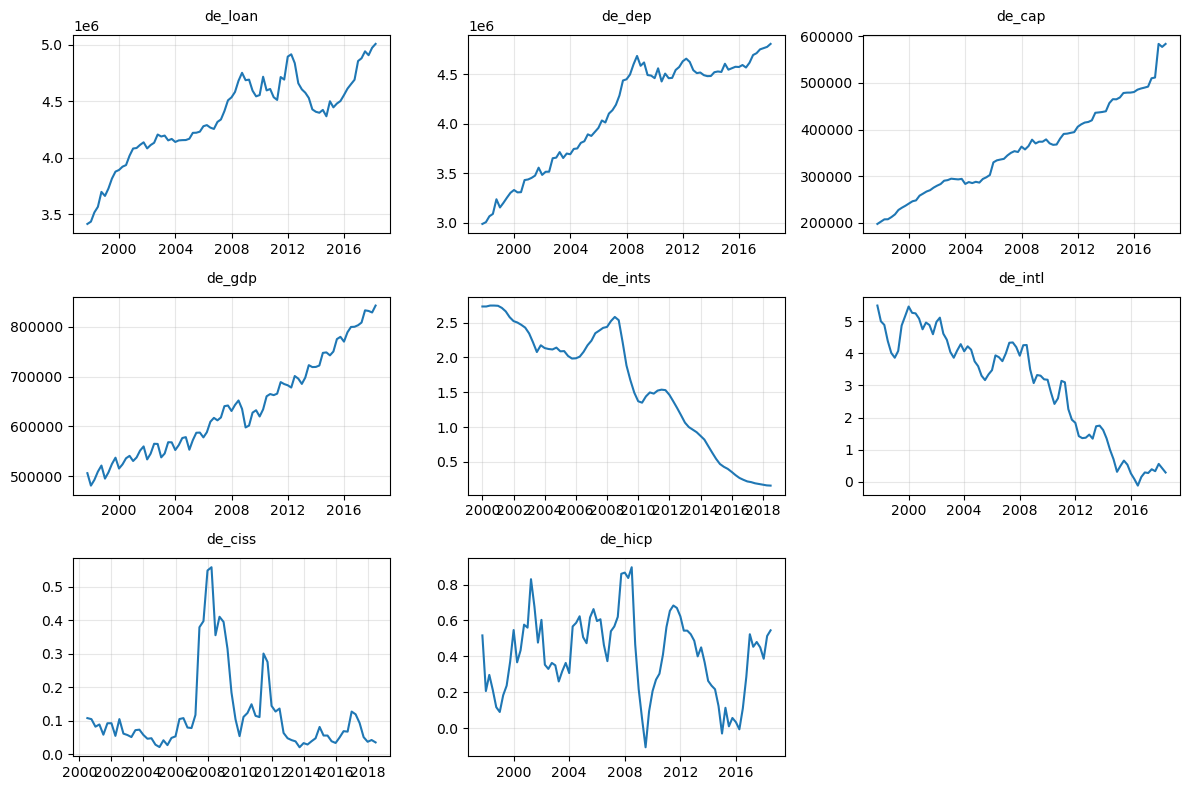

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(12,8))
axes_flat = axes.flatten()
columns = final_df.columns.tolist()
for i, col in enumerate(columns):
    ax = axes_flat[i]
    x_values = final_df.index.to_timestamp() if hasattr(final_df.index, 'to_timestamp') else final_df.index
    ax.plot(x_values, final_df[col], linewidth=1.5)
    ax.set_title(col, fontsize=10, pad=10)
    ax.grid(True, alpha=0.3)

# Hide the extra subplot (since we have 8 variables in a 3x3 grid)
axes_flat[8].set_visible(False)
plt.tight_layout()
plt.show()


#### Seasonality
There is clear seasonality in GDP
What about seasonality in banking series? Graphical analysis suggests that it is not the case, but we can formally check.

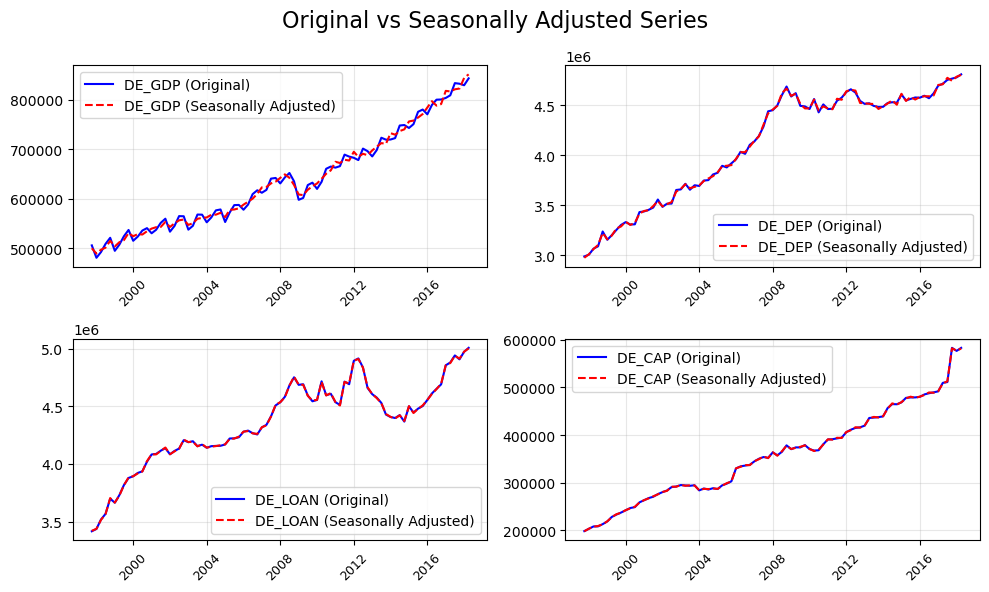

In [13]:
# Seasonal adjustement of banking series using seasonal_decompose from statsmodel
from statsmodels.tsa.seasonal import seasonal_decompose

seasonadj_vars = ['de_gdp','de_dep','de_loan','de_cap']
for var in seasonadj_vars:
    decomp = seasonal_decompose(final_df[var].dropna(), model='multiplicative', period=4)
    final_df[f'{var}_sa'] = final_df[var] / decomp.seasonal

# Let's plot to see
fig, axes = plt.subplots(2,2,figsize=(10,6))
axes = axes.flatten()
fig.suptitle('Original vs Seasonally Adjusted Series', fontsize=16)

for i, var in enumerate(seasonadj_vars):
    ax = axes[i]
    
    # Convert index to timestamps if needed for plotting
    x_values = final_df.index.to_timestamp() if hasattr(final_df.index, 'to_timestamp') else final_df.index
    
    # Plot original and seasonally adjusted series
    ax.plot(x_values, final_df[var], label=f'{var.upper()} (Original)', 
            linewidth=1.5, color='blue')
    ax.plot(x_values, final_df[f'{var}_sa'], label=f'{var.upper()} (Seasonally Adjusted)', 
            linewidth=1.5, color='red', linestyle='--')
    
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45, labelsize=9)

plt.tight_layout()
plt.show()

#### Further graphical analysis

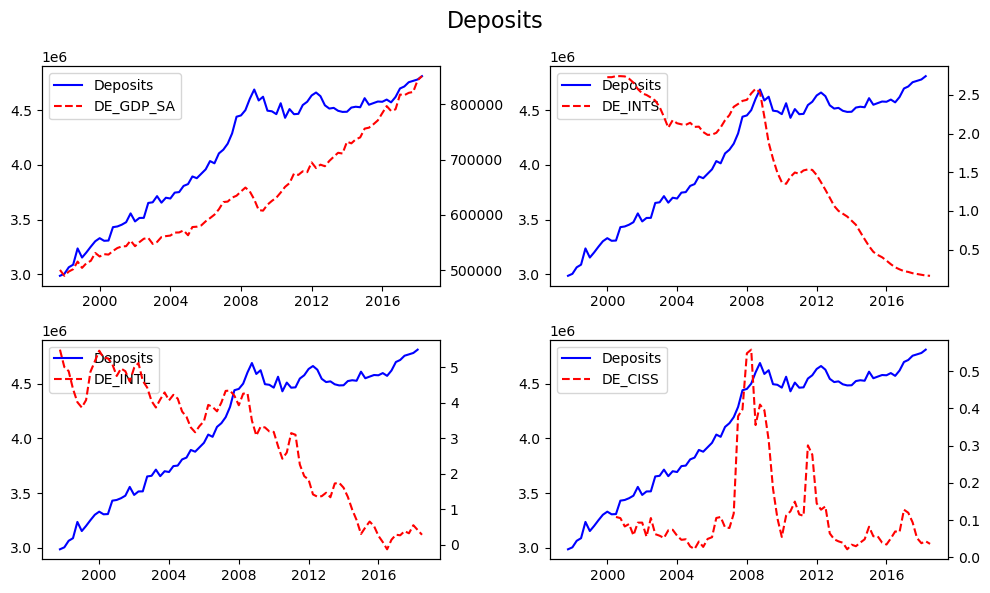

In [14]:

fig, axes = plt.subplots(2, 2, figsize=(10,6))
axes = axes.flatten()  # flatten 2x2 grid
fig.suptitle('Deposits', fontsize=16)

var_list = ['de_gdp_sa','de_ints','de_intl','de_ciss']

for i, var in enumerate(var_list):
    ax = axes[i]
    x_values = final_df.index.to_timestamp() if hasattr(final_df.index, 'to_timestamp') else final_df.index
    line1, = ax.plot(x_values, final_df['de_dep'], linewidth=1.5, color='blue', label='Deposits')
    
    # right y-axis
    ax2 = ax.twinx()
    line2, = ax2.plot(x_values, final_df[var], linewidth=1.5, color='red', linestyle='--', label=f'{var.upper()}')
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax.legend(lines, labels, loc="upper left")

plt.tight_layout()
plt.show()

**Comments:**
Those figures don't say much: 
- in the upper-left chart, both series have an upward trend so it's hard to distinguish higher frequency common movements although there seems to be a negative correlation around the crisis in 2009
- the others charts are not useful because we plot a trending series against series that are *supposed to be* stationary (interest rates, but clearly they are not over that time window)

$\Rightarrow$ let's look at the same figure but with the yoy growth rate of deposits instead of the level

In [15]:
# generate variables in y-o-y growth  
var_yoyg = ['de_gdp','de_loan','de_dep']
for i, var in enumerate(var_yoyg):
    final_df[f'{var}_g'] = final_df[var].pct_change(4,fill_method=None)*100

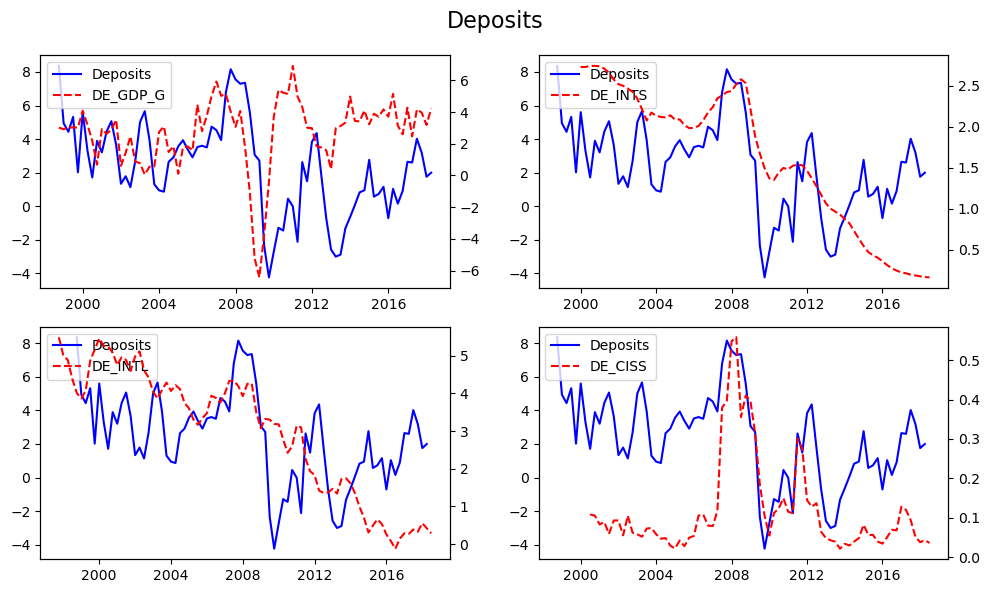

In [16]:
# plot
fig, axes = plt.subplots(2, 2, figsize=(10,6))
axes = axes.flatten()  # flatten 2x2 grid
fig.suptitle('Deposits', fontsize=16)

var_list = ['de_gdp_g','de_ints','de_intl','de_ciss']

for i, var in enumerate(var_list):
    ax = axes[i]
    x_values = final_df.index.to_timestamp() if hasattr(final_df.index, 'to_timestamp') else final_df.index
    line1, = ax.plot(x_values, final_df['de_dep_g'], linewidth=1.5, color='blue', label='Deposits')
    
    # right y-axis
    ax2 = ax.twinx()
    line2, = ax2.plot(x_values, final_df[var], linewidth=1.5, color='red', linestyle='--', label=f'{var.upper()}')
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax.legend(lines, labels, loc="upper left")

plt.tight_layout()
plt.show()

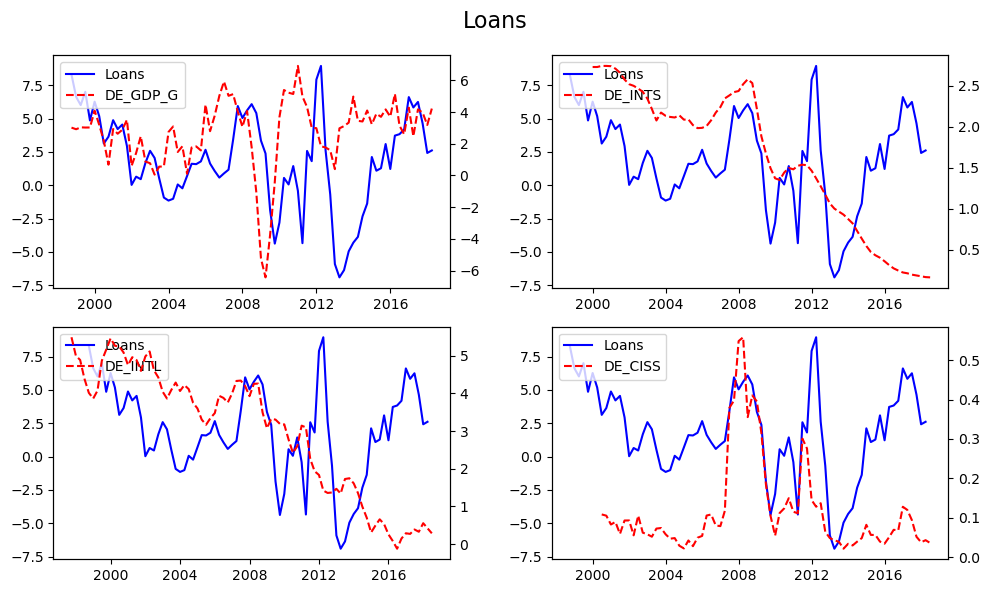

In [17]:
# plot
fig, axes = plt.subplots(2, 2, figsize=(10,6))
axes = axes.flatten()  # flatten 2x2 grid
fig.suptitle('Loans', fontsize=16)

var_list = ['de_gdp_g','de_ints','de_intl','de_ciss']

for i, var in enumerate(var_list):
    ax = axes[i]
    x_values = final_df.index.to_timestamp() if hasattr(final_df.index, 'to_timestamp') else final_df.index
    line1, = ax.plot(x_values, final_df['de_loan_g'], linewidth=1.5, color='blue', label='Loans')
    
    # right y-axis
    ax2 = ax.twinx()
    line2, = ax2.plot(x_values, final_df[var], linewidth=1.5, color='red', linestyle='--', label=f'{var.upper()}')
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax.legend(lines, labels, loc="upper left")

plt.tight_layout()
plt.show()

## ARMA Modelling
Below are the standard steps to apply the Box-Jenkins methodology
1) Stationarity check
2) ACF and PACF plots
3) Estimatioon
4) Diagnostic checks

#### 1. Stationarity checks

In [18]:
from statsmodels.tsa.stattools import adfuller

# Let's try different specifications
specs = [('n', 'No constant, no trend'), 
         ('c', 'Constant'), 
         ('ct', 'Constant and trend')]

# Run tests and collect results
results = []
for spec_code, spec_name in specs:
    adf_result = adfuller(final_df['de_loan'].dropna(), regression=spec_code, autolag='AIC')
    results.append({
        'Specification': spec_name,
        'ADF Statistic': f"{adf_result[0]:.4f}",
        'P-value': f"{adf_result[1]:.4f}",
        'Critical Value (99%) ': f"{adf_result[4]['1%']:.4f}"
    })

# Create results table
results_df = pd.DataFrame(results)
print("ADF Test Results for loan series")
print("=" * 70)
print(results_df.to_string(index=False))

print("\nNote: H0 = Unit root (non-stationary), H1 = Stationary")


ADF Test Results for loan series
        Specification ADF Statistic P-value Critical Value (99%) 
No constant, no trend        2.4738  0.9979               -2.5935
             Constant       -1.6931  0.4347               -3.5149
   Constant and trend       -2.8372  0.1836               -4.0766

Note: H0 = Unit root (non-stationary), H1 = Stationary


So we can't reject H0 for the three specifications $\Rightarrow$ evidence of a unit root and series needs first differencing

In [19]:
# Let's create the series in first differences and check whether it's stationary
final_df['de_loan_d'] = final_df['de_loan'].diff()

# Now we run the ADF tests again
results = []
for spec_code, spec_name in specs:
    adf_result = adfuller(final_df['de_loan_d'].dropna(), regression=spec_code, autolag='AIC')
    results.append({
        'Specification': spec_name,
        'ADF Statistic': f"{adf_result[0]:.4f}",
        'P-value': f"{adf_result[1]:.4f}",
        'Critical Value (99%) ': f"{adf_result[4]['1%']:.4f}"
    })

results_df = pd.DataFrame(results)
print("ADF Test Results for loan series in first differences")
print("=" * 70)
print(results_df.to_string(index=False))


ADF Test Results for loan series in first differences
        Specification ADF Statistic P-value Critical Value (99%) 
No constant, no trend       -4.4276  0.0000               -2.5943
             Constant       -4.7988  0.0001               -3.5149
   Constant and trend       -4.7793  0.0005               -4.0766


So we reject the null of a unit root for all specification $\Rightarrow$ series is stationary.  
However, formally conducting the test is not necessary. Usually, visual inspection is largely enough. Let's look at the series:

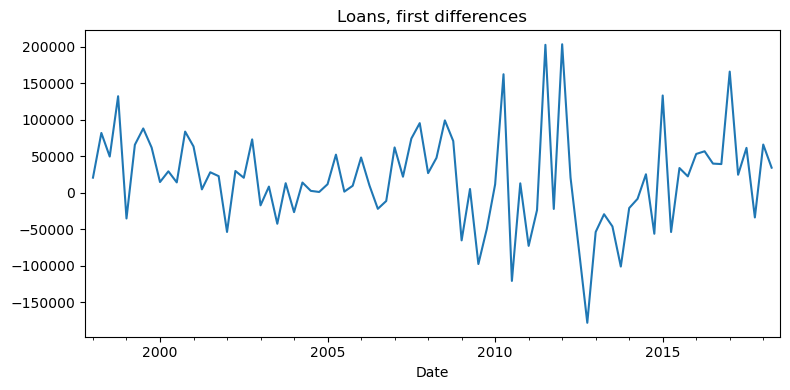

In [20]:
plt.figure(figsize=(8,4))
final_df['de_loan_d'].plot(title="Loans, first differences")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


In [21]:
# Now we do the exact same thing for deposits
results = []
for spec_code, spec_name in specs:
    adf_result = adfuller(final_df['de_dep'].dropna(), regression=spec_code, autolag='AIC')
    results.append({
        'Specification': spec_name,
        'ADF Statistic': f"{adf_result[0]:.4f}",
        'P-value': f"{adf_result[1]:.4f}",
        'Critical Value (99%) ': f"{adf_result[4]['1%']:.4f}"
    })

# Create results table
results_df = pd.DataFrame(results)
print("ADF Test Results for deposits series")
print("=" * 70)
print(results_df.to_string(index=False))

ADF Test Results for deposits series
        Specification ADF Statistic P-value Critical Value (99%) 
No constant, no trend        2.4289  0.9975               -2.5943
             Constant       -1.6349  0.4649               -3.5183
   Constant and trend       -1.5138  0.8244               -4.0766


ADF Test Results for deposits series in first differences
        Specification ADF Statistic P-value Critical Value (99%) 
No constant, no trend       -2.6348  0.0082               -2.5954
             Constant       -5.2773  0.0000               -3.5149
   Constant and trend       -3.7101  0.0217               -4.0814





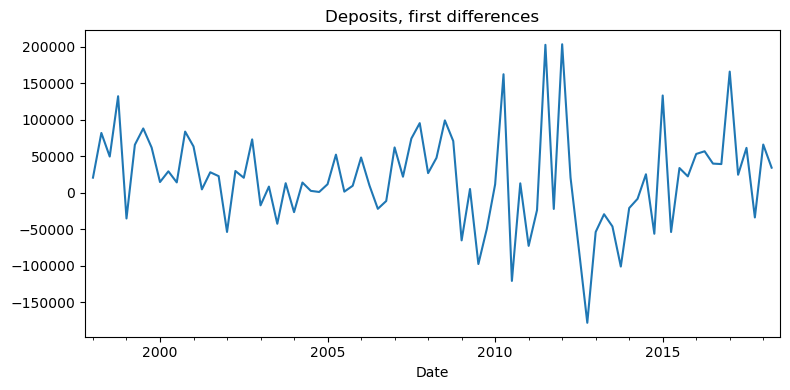

In [22]:
final_df['de_dep_d'] = final_df['de_dep'].diff()

# Now we run the ADF tests again
results = []
for spec_code, spec_name in specs:
    adf_result = adfuller(final_df['de_dep_d'].dropna(), regression=spec_code, autolag='AIC')
    results.append({
        'Specification': spec_name,
        'ADF Statistic': f"{adf_result[0]:.4f}",
        'P-value': f"{adf_result[1]:.4f}",
        'Critical Value (99%) ': f"{adf_result[4]['1%']:.4f}"
    })

results_df = pd.DataFrame(results)
print("ADF Test Results for deposits series in first differences")
print("=" * 70)
print(results_df.to_string(index=False))
print('\n\n')

# plot
plt.figure(figsize=(8,4))
final_df['de_loan_d'].plot(title="Deposits, first differences")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

#### 2. Identification and estimation
Remember:
- For an MA(q) process, the ACF will cut sharply after q lags. For an AR(p) process, we'll see a gradual decay of the ACF
- For an AR(p) process, the PACF will cut sharply after p lags, while it will gradually decay for an MA process
- In many applications (as here), this is not as simple

##### 2.1. Deposits, first differences

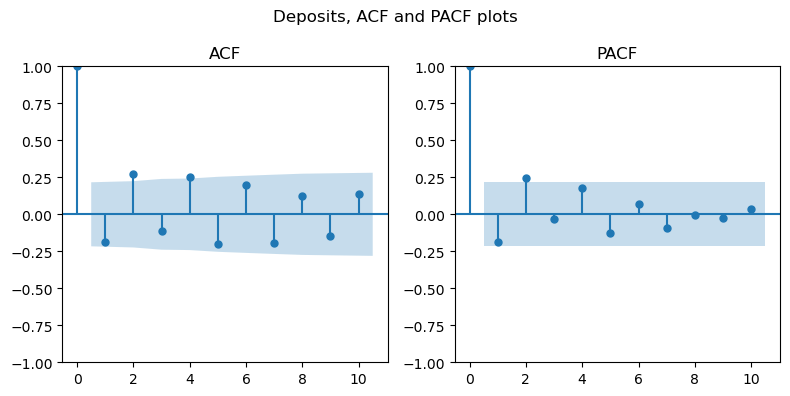

In [23]:
# we begin with ACF and PACF plots to determine the possible order of the AR and MA components
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Deposits, ACF and PACF plots')
# ACF plot
plot_acf(final_df['de_dep_d'].dropna(), lags=10, ax=axes[0], title='ACF')

# PACF plot
plot_pacf(final_df['de_dep_d'].dropna(), lags=10, ax=axes[1], title='PACF')

plt.tight_layout()
plt.show()

So we see neither clear cutoff nor asymptotical decay in both the ACF or PACF $\Rightarrow$ inconclusive results.  

We then move to "trial and error". Because we're dealing with quarterly data, we will try AR(4) and MA(4) specifications.

In [24]:
from statsmodels.tsa.arima.model import ARIMA

# AR(4)
series = final_df['de_dep_d'].dropna()
model = ARIMA(series, order=(4,0,0))  
result_ar4 = model.fit()
print(result_ar4.summary())

                               SARIMAX Results                                
Dep. Variable:               de_dep_d   No. Observations:                   82
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -1006.771
Date:                Thu, 25 Sep 2025   AIC                           2025.543
Time:                        15:41:21   BIC                           2039.983
Sample:                    03-31-1998   HQIC                          2031.340
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.221e+04   7738.770      2.871      0.004    7046.985    3.74e+04
ar.L1         -0.1275      0.112     -1.137      0.255      -0.347       0.092
ar.L2          0.1940      0.108      1.793      0.0

To note about the results:
- Ljung-Box test: HO: residuals are **not** autocorrelated. we can't reject, so OK
- Heteroskedasticity: H0 is homeskedastic variance. we can't reject, so OK
- Jarque-Bera is for normality of residuals, H0 is that they are normally distributed. we can't reject, so OK
$\Rightarrow$ the residuals pass the diagnostic checks.

However, many of the lags are not significant, se we may want to try a more parsimonious spec.

In [25]:
# MA(4)
series = final_df['de_dep_d'].dropna()
model = ARIMA(series, order=(0,0,4))  
result_ma4 = model.fit()
print(result_ma4.summary())

                               SARIMAX Results                                
Dep. Variable:               de_dep_d   No. Observations:                   82
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -1007.985
Date:                Thu, 25 Sep 2025   AIC                           2027.971
Time:                        15:41:22   BIC                           2042.411
Sample:                    03-31-1998   HQIC                          2033.769
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.221e+04   7774.544      2.857      0.004    6976.869    3.75e+04
ma.L1         -0.1219      0.114     -1.069      0.285      -0.345       0.102
ma.L2          0.1947      0.128      1.517      0.1

That's also pretty bad. Let's try ARMA(1,1)

In [26]:
# ARMA(1,1)
series = final_df['de_dep_d'].dropna()
model = ARIMA(series, order=(1,0,1))  
result_arma11 = model.fit()

print(result_arma11.summary())

                               SARIMAX Results                                
Dep. Variable:               de_dep_d   No. Observations:                   82
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1005.756
Date:                Thu, 25 Sep 2025   AIC                           2019.511
Time:                        15:41:23   BIC                           2029.138
Sample:                    03-31-1998   HQIC                          2023.376
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.221e+04   6013.422      3.694      0.000    1.04e+04     3.4e+04
ar.L1         -0.9831      0.026    -37.334      0.000      -1.035      -0.931
ma.L1          0.9111      0.083     10.975      0.0

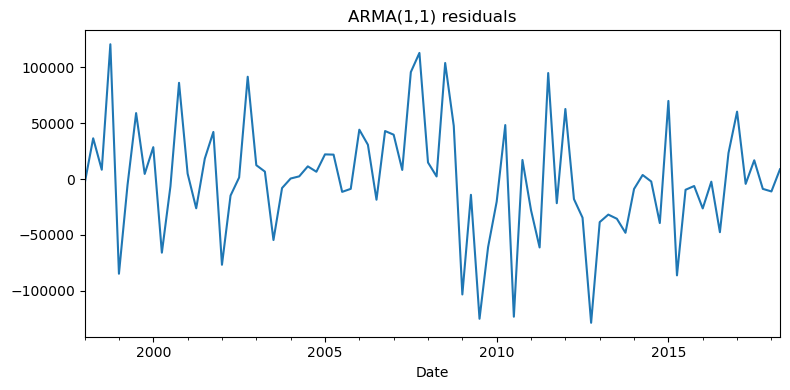

In [27]:
# let's graphically look at residuals
resid_arma11 = result_arma11.resid

plt.figure(figsize=(8,4))
resid_arma11.plot(title="ARMA(1,1) residuals")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

Residuals seems lower from 2009, let's check this

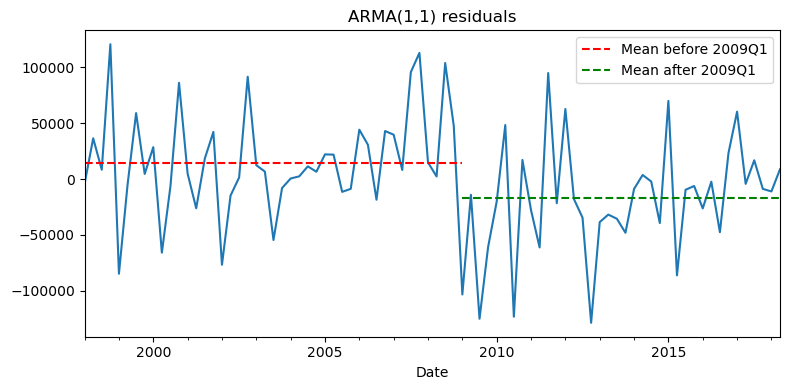

In [30]:
# break date
break_date = "2009Q1"

# split residuals
pre_resid = resid_arma11[resid_arma11.index <= break_date]
post_resid = resid_arma11[resid_arma11.index > break_date]

# compute means
pre_mean = pre_resid.mean()
post_mean = post_resid.mean()

# plot
plt.figure(figsize=(8,4))
resid_arma11.plot(title="ARMA(1,1) residuals")
plt.xlabel("Date")
# add horizontal lines
plt.plot([resid_arma11.index[0],pd.Period(break_date, freq='Q')],[pre_mean,pre_mean], color='red', linestyle='--', label='Mean before 2009Q1')
plt.plot([pd.Period(break_date, freq='Q'),resid_arma11.index[-1]],[post_mean,post_mean], color='green', linestyle='--', label='Mean after 2009Q1')

plt.legend()
plt.tight_layout()
plt.show()

So we now try fitting an ARMA(1,1) with a step dummy from 2009Q1. To be clear, that means estimating the following model

$
y_t = c + aD_t + \rho y_{t-1} + \varepsilon_t + \theta \varepsilon_{t-1}
$

where $D_t=0$ for $t<2009Q1$ and $D_t=1$ elsewhere

In [31]:
# Let's fit the process above
series = final_df['de_dep_d'].dropna()

# create the step dummy
dummy = (series.index >= "2009Q1").astype(int)

# define and fit the model
model = ARIMA(series, order=(1,0,1), exog=dummy)
result_arma11_dum = model.fit()
print(result_arma11_dum.summary())

                               SARIMAX Results                                
Dep. Variable:               de_dep_d   No. Observations:                   82
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1000.177
Date:                Thu, 25 Sep 2025   AIC                           2010.354
Time:                        15:42:02   BIC                           2022.387
Sample:                    03-31-1998   HQIC                          2015.185
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.863e+04   7838.231      4.928      0.000    2.33e+04     5.4e+04
x1         -3.542e+04    1.1e+04     -3.223      0.001    -5.7e+04   -1.39e+04
ar.L1         -0.9818      0.028    -35.243      0.0

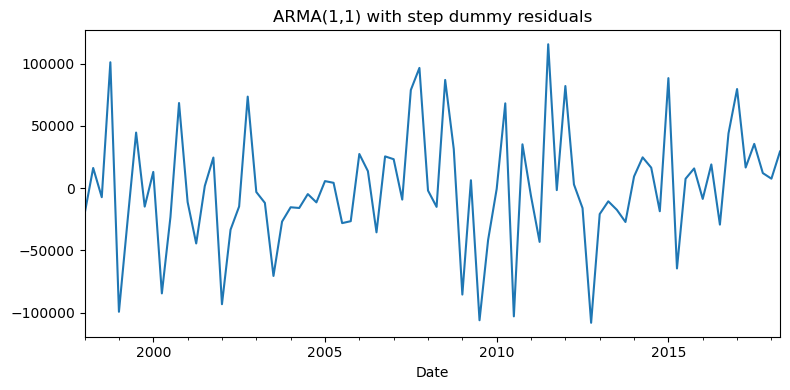

In [32]:
# let's graphically look at residuals
resid_arma11_dum = result_arma11_dum.resid

plt.figure(figsize=(8,4))
resid_arma11_dum.plot(title="ARMA(1,1) with step dummy residuals")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

In [33]:
# Now let's compare the fit of the 4 models we've estimated so far

# Collect the results in a dictionary
models = {
    'AR(4)': result_ar4,
    'MA(4)': result_ma4,
    'ARMA(1,1)': result_arma11,
    'ARMA(1,1) + Dummy': result_arma11_dum
}

# Create a summary table
summary_data = []

for name, res in models.items():
    summary_data.append({
        'Model': name,
        'AIC': res.aic,
        'BIC': res.bic,
        'Log-Likelihood': res.llf
    })

fit_table = pd.DataFrame(summary_data)
fit_table.set_index('Model', inplace=True)
print("="*60)
print(fit_table.to_string())

                           AIC          BIC  Log-Likelihood
Model                                                      
AR(4)              2025.542774  2039.983089    -1006.771387
MA(4)              2027.970973  2042.411289    -1007.985487
ARMA(1,1)          2019.511412  2029.138289    -1005.755706
ARMA(1,1) + Dummy  2010.353851  2022.387448    -1000.176926


Clearly the best best fit is for the ARMA(1,1) with the step dummy

In [34]:
# In Python we can also do automatic model selection based on information criteria.
import pmdarima as pm

series = final_df['de_dep_d'].dropna()

# Automatic ARMA/ARIMA selection
model_sel = pm.auto_arima(
    series,
    start_p=0, max_p=5,        # AR order range
    start_q=0, max_q=5,        # MA order range
    d=0,                        # No differencing, we already work with the series in first differences
    seasonal=False,             # no seasonal adjustment needed
    stepwise=True,              # Faster search
    information_criterion='aic' # we could use something else
)

print("Selected ARMA order:", model_sel.order)

Selected ARMA order: (1, 0, 1)


So we see that the model selection that tries all the AR-MA combinations up to 5 lags in each polynaomials also picks an ARMA(1,1).  

Next, we try to fit models on the yoy growth rate series instead of that in first differences

##### 2.1. Deposits, growth rates

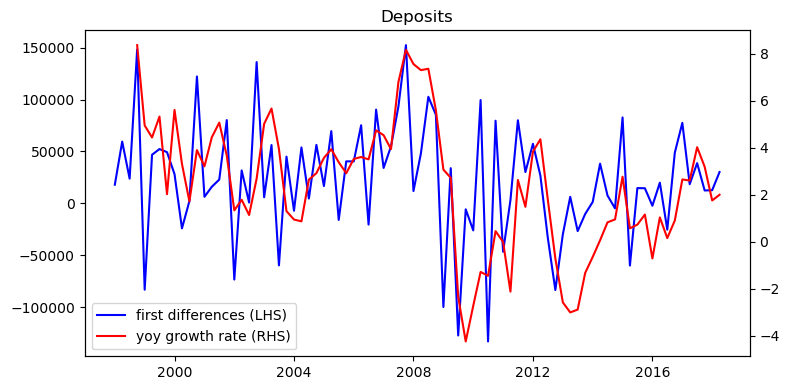

In [35]:
fig, ax = plt.subplots(figsize=(8,4))
x_values = final_df.index.to_timestamp() if hasattr(final_df.index, 'to_timestamp') else final_df.index
line1, = ax.plot(x_values, final_df['de_dep_d'], linewidth=1.5, color='blue', label='first differences (LHS)')
ax2 = ax.twinx()
line2, = ax2.plot(x_values, final_df['de_dep_g'], linewidth=1.5, color='red', label='yoy growth rate (RHS)')
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc="lower left")
plt.title('Deposits')
plt.tight_layout()
plt.show()

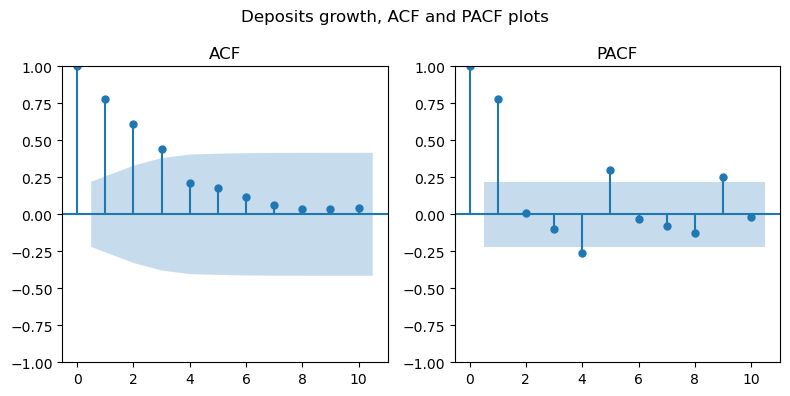

In [36]:
# Now we look again at ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Deposits growth, ACF and PACF plots')
# ACF plot
plot_acf(final_df['de_dep_g'].dropna(), lags=10, ax=axes[0], title='ACF')

# PACF plot
plot_pacf(final_df['de_dep_g'].dropna(), lags=10, ax=axes[1], title='PACF')

plt.tight_layout()
plt.show()

Ok, now that's interesting because those are much more telling than for the series in first differences
- ACF is decaying gradually $\Rightarrow$ suggestive of an AR process
- PACF cuts sharply after 1 lag, which is indicative of an AR(1) process

In [37]:
series = final_df['de_dep_g'].dropna()
model = ARIMA(series, order=(1,0,0))
result_ar1_g = model.fit()
print(result_ar1_g.summary())

                               SARIMAX Results                                
Dep. Variable:               de_dep_g   No. Observations:                   79
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -150.282
Date:                Thu, 25 Sep 2025   AIC                            306.563
Time:                        15:42:18   BIC                            313.672
Sample:                    12-31-1998   HQIC                           309.411
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6496      0.846      3.131      0.002       0.991       4.308
ar.L1          0.8204      0.062     13.136      0.000       0.698       0.943
sigma2         2.5923      0.376      6.895      0.0

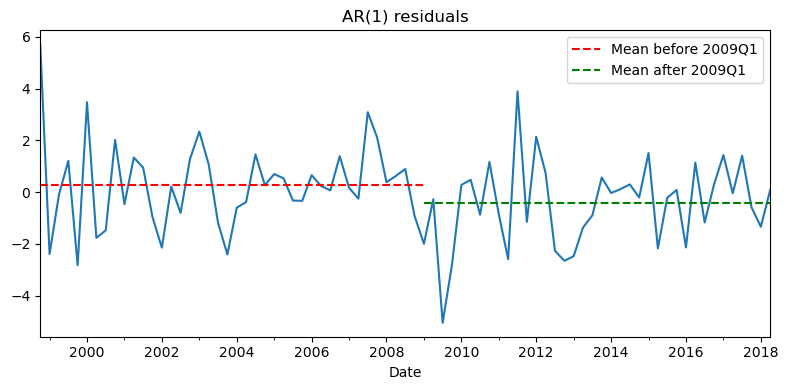

In [38]:
# let's look at whether we have the same problem with residuals as the series in first differences
resid_g_ar1 = result_ar1_g.resid
# split residuals
pre_resid = resid_g_ar1[resid_g_ar1.index <= break_date]
post_resid = resid_g_ar1[resid_g_ar1.index > break_date]

# compute means
pre_mean = pre_resid.mean()
post_mean = post_resid.mean()

# plot
plt.figure(figsize=(8,4))
resid_g_ar1.plot(title="AR(1) residuals")
plt.xlabel("Date")
# add horizontal lines
plt.plot([resid_g_ar1.index[0],pd.Period(break_date, freq='Q')],[pre_mean,pre_mean], color='red', linestyle='--', label='Mean before 2009Q1')
plt.plot([pd.Period(break_date, freq='Q'),resid_g_ar1.index[-1]],[post_mean,post_mean], color='green', linestyle='--', label='Mean after 2009Q1')

plt.legend()
plt.tight_layout()
plt.show()

In [39]:
# Not so clear, but let's try with the step dummy regardless
series = final_df['de_dep_g'].dropna()
dummy_g = (series.index >= "2009Q1").astype(int)
model = ARIMA(series, order=(1,0,0),exog=dummy_g)
result_ar1_dum_g = model.fit()
print(result_ar1_dum_g.summary())

                               SARIMAX Results                                
Dep. Variable:               de_dep_g   No. Observations:                   79
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -146.012
Date:                Thu, 25 Sep 2025   AIC                            300.023
Time:                        15:42:35   BIC                            309.501
Sample:                    12-31-1998   HQIC                           303.820
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1400      0.660      6.275      0.000       2.847       5.433
x1            -3.3944      0.938     -3.618      0.000      -5.233      -1.556
ar.L1          0.6844      0.088      7.776      0.0

In [40]:
# Let's see what the model selection would yield
series = final_df['de_dep_g'].dropna()

# Automatic ARMA/ARIMA selection
model_sel = pm.auto_arima(
    series,
    start_p=0, max_p=5,        # AR order range
    start_q=0, max_q=5,        # MA order range
    d=0,                        # No differencing, we already work with the series in first differences
    seasonal=False,             # no seasonal adjustment needed
    stepwise=True,              # Faster search
    information_criterion='aic' # we could use something else
)

print("Selected ARMA order:", model_sel.order)

Selected ARMA order: (0, 0, 3)


Suggests an MA(3), which was not evident from ACF.

In [41]:
series = final_df['de_dep_g'].dropna()
model = ARIMA(series, order=(0,0,3))
result_ma3_g = model.fit()
print(result_ma3_g.summary())

                               SARIMAX Results                                
Dep. Variable:               de_dep_g   No. Observations:                   79
Model:                 ARIMA(0, 0, 3)   Log Likelihood                -136.225
Date:                Thu, 25 Sep 2025   AIC                            282.450
Time:                        15:42:40   BIC                            294.297
Sample:                    12-31-1998   HQIC                           287.197
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4299      0.518      4.692      0.000       1.415       3.445
ma.L1          0.9182      0.076     12.121      0.000       0.770       1.067
ma.L2          0.9239      0.087     10.623      0.0

In [42]:
# let's summarise the fit of the 3 models we've estimated for the series in growth

# Collect the results in a dictionary
models = {
    'AR(1)': result_ar1_g,
    'AR(1) + dummy': result_ar1_dum_g,
    'MA(3)': result_ma3_g
}

# Create a summary table
summary_data = []

for name, res in models.items():
    summary_data.append({
        'Model': name,
        'AIC': res.aic,
        'BIC': res.bic,
        'Log-Likelihood': res.llf
    })

fit_table = pd.DataFrame(summary_data)
fit_table.set_index('Model', inplace=True)
print("="*60)
print(fit_table.to_string())

                      AIC         BIC  Log-Likelihood
Model                                                
AR(1)          306.563220  313.671564     -150.281610
AR(1) + dummy  300.023076  309.500867     -146.011538
MA(3)          282.450179  294.297418     -136.225090


## Loans
Repeat the analysis on your own for loans